In [1]:
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
library(car)
library(multcomp)
library(multcompView)
library(ggpubr)

theme_set(ggthemes::theme_few() + theme(text = element_text(size = 14), strip.text = element_text(size = 16)))
myColorPalette <- c("#005AB5","#DC3220")
options(repr.plot.width=5, repr.plot.height=5)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 

In [2]:
up <- read.csv("./datasets/MOA_UPurdue.csv") %>%
gather(variable,value,-year:-n_rate)  %>% 
separate(variable,c("stage","organ","measurement","units"),sep = "_")

up$microbe <- factor(up$microbe, levels = c('UTC','PROVEN40'),  labels = c('Uninoculated Control','PROVEN40'))
up$stage <- factor(up$stage, levels = c('V8','R1','R6'))
up$n_rate <- factor(up$n_rate)


In [3]:
# Helper function to check model assumptions   
check_assumptions <- function(mod) {

   print(plot(mod)) # resid x pred
   print(plot(density(resid(mod))))  #A density plot
   # Make sure the residuals are normal
   shapiro.test(residuals(mod)) 
}

In [4]:
unique(up$organ)

[1] "leaftip" "shoot"   "leaf"    "stem"    "ear"     "kernel"

In [5]:
up_n <- up %>% 
filter(measurement == "n",organ == "shoot")

In [6]:
up_n <- up_n %>% mutate_at(c("year","rep","microbe","stage","plot","organ"), factor)


In [7]:
# test for HOV across treatments
leveneTest(value ~ microbe, data=up_n)
leveneTest(value ~ n_rate, data=up_n)
leveneTest(value ~ year, data=up_n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.07887828,0.7789267
,562,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,27.82482,3.424038e-25
,558,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,9.065656,0.002721561
,562,NA,NA


In [8]:
# test for HOV across treatments
leveneTest(log(value) ~ microbe, data=up_n)
leveneTest(log(value) ~ n_rate, data=up_n)
leveneTest(log(value) ~ year, data=up_n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.1808592,0.6707987
,562,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,2.072906,0.06724466
,558,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,3.499395,0.06191075
,562,NA,NA


In [9]:
up21_n <- filter(up_n, year == 2021)

head(up21_n)

,year,plot,rep,microbe,n_rate,stage,organ,measurement,units,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>
1,2021,101,1,PROVEN40,0,V8,shoot,n,kgha,40.29999
2,2021,102,1,Uninoculated Control,0,V8,shoot,n,kgha,22.48533
3,2021,103,1,PROVEN40,95,V8,shoot,n,kgha,41.53138
4,2021,104,1,Uninoculated Control,95,V8,shoot,n,kgha,36.77374
5,2021,107,1,PROVEN40,175,V8,shoot,n,kgha,57.74955
6,2021,108,1,Uninoculated Control,175,V8,shoot,n,kgha,37.19741


In [10]:
up21_n_mod_full <- lmer(log(value) ~ microbe*n_rate*stage +  (1|rep/n_rate), data = up21_n)

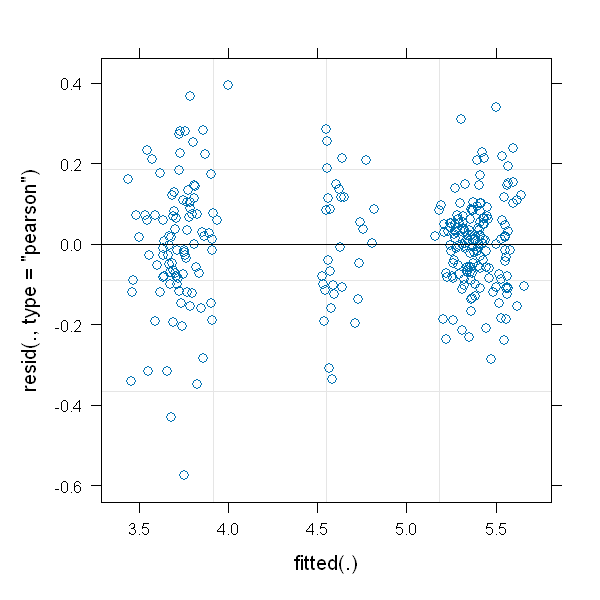

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98305, p-value = 0.001732


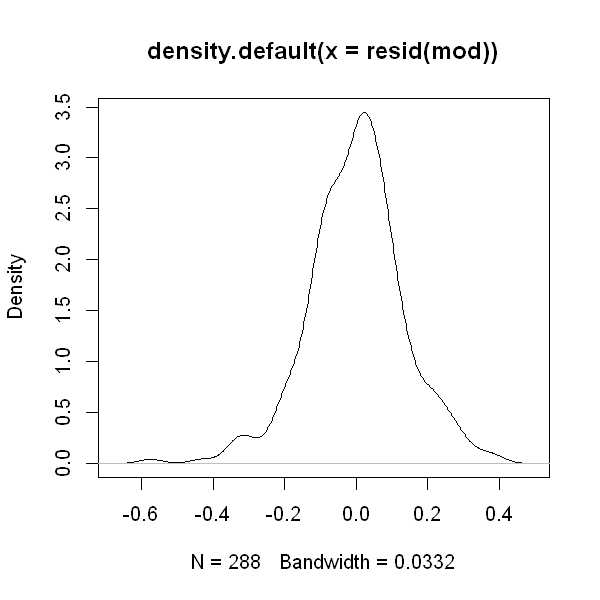

In [11]:
check_assumptions(up21_n_mod_full)

In [12]:
anova(up21_n_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
microbe,0.3511619,0.35116186,1,210.00004,15.8017424,9.673140e-05
n_rate,7.7873481,1.55746962,5,41.99995,70.0837311,2.796377e-19
stage,152.5791629,76.28958145,2,210.00004,3432.9135257,4.040131e-161
microbe:n_rate,0.1228116,0.02456233,5,210.00004,1.1052670,3.586435e-01
microbe:stage,0.3792827,0.18964136,2,210.00004,8.5335689,2.734173e-04
n_rate:stage,4.0708126,0.40708126,10,210.00004,18.3180288,6.892118e-24
microbe:n_rate:stage,0.1125362,0.01125362,10,210.00004,0.5063957,8.844988e-01


In [13]:
up21_n_mod_red1 <- lmer(log(value) ~ microbe*stage + n_rate*stage  +  (1|rep:n_rate), data = up21_n)

In [14]:
summary(up21_n_mod_red1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ microbe * stage + n_rate * stage + (1 | rep:n_rate)
   Data: up21_n

REML criterion at convergence: -180.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1690 -0.5569  0.0508  0.4974  2.9974 

Random effects:
 Groups     Name        Variance Std.Dev.
 rep:n_rate (Intercept) 0.002852 0.0534  
 Residual               0.021787 0.1476  
Number of obs: 288, groups:  rep:n_rate, 48

Fixed effects:
                         Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)               3.51424    0.04410 177.14537  79.682  < 2e-16 ***
microbePROVEN40           0.17009    0.03013 225.00000   5.645 4.94e-08 ***
stageR1                   1.14144    0.05637 225.00000  20.250  < 2e-16 ***
stageR6                   1.06113    0.05637 225.00000  18.825  < 2e-16 ***
n_rate95                  0.13224    0.05862 152.97576   2.256  0.02549 *  
n_rate135               

In [15]:
up21_n_mod<- up21_n_mod_red1

In [16]:
up21_n_mod_means <- emmeans(up21_n_mod, ~ stage*microbe + n_rate*stage,  type = "response")
up21_n_mod_means

 stage microbe              n_rate response    SE  df lower.CL upper.CL
 V8    Uninoculated Control 0          33.6  1.48 177     30.8     36.6
 R1    Uninoculated Control 0         105.2  4.64 177     96.4    114.7
 R6    Uninoculated Control 0          97.1  4.28 177     89.0    105.9
 V8    PROVEN40             0          39.8  1.76 177     36.5     43.4
 R1    PROVEN40             0         109.3  4.82 177    100.2    119.3
 R6    PROVEN40             0          97.1  4.28 177     89.0    106.0
 V8    Uninoculated Control 95         38.3  1.69 177     35.1     41.8
 R1    Uninoculated Control 95        183.9  8.11 177    168.6    200.6
 R6    Uninoculated Control 95        195.1  8.61 177    178.9    212.9
 V8    PROVEN40             95         45.4  2.00 177     41.7     49.6
 R1    PROVEN40             95        191.2  8.43 177    175.2    208.5
 R6    PROVEN40             95        195.2  8.61 177    179.0    213.0
 V8    Uninoculated Control 135        36.4  1.61 177     33.4  

In [17]:
up21_n_mod_trt_contrast <- emmeans(up21_n_mod, ~ microbe, by = c("stage"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up21_n_mod_trt_contrast <- 
up21_n_mod_trt_contrast %>%
left_join(as.data.frame(up21_n_mod_means) %>% filter(microbe == "Uninoculated Control") %>% dplyr::select(stage,n_rate,response))  %>% 
mutate(pct_change = round(ratio - 1,3)*100,
my_label = 
paste0(
    pct_change,"% change\n",
    "p = ",signif(p.value,2)
    )
) %>% 
left_join(up21_n_mod_means %>% 
as.data.frame() %>%  
group_by(stage) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up21_n_mod_trt_contrast
 

Joining with `by = join_by(stage)`
Joining with `by = join_by(stage)`


contrast,stage,ratio,SE,df,null,t.ratio,p.value,n_rate,response,pct_change,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,0,33.59049,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,95,38.33972,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,135,36.42203,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,175,39.49069,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,215,40.34483,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,V8,1.185409,0.03571624,225,1,5.64515151,4.944874e-08,255,40.36505,18.5,18.5% change p = 4.9e-08,52.20028
PROVEN40 / Uninoculated Control,R1,1.039556,0.03132170,225,1,1.28754383,1.992276e-01,0,105.18129,4.0,4% change p = 0.2,243.78793
PROVEN40 / Uninoculated Control,R1,1.039556,0.03132170,225,1,1.28754383,1.992276e-01,95,183.87728,4.0,4% change p = 0.2,243.78793
PROVEN40 / Uninoculated Control,R1,1.039556,0.03132170,225,1,1.28754383,1.992276e-01,135,198.77307,4.0,4% change p = 0.2,243.78793


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


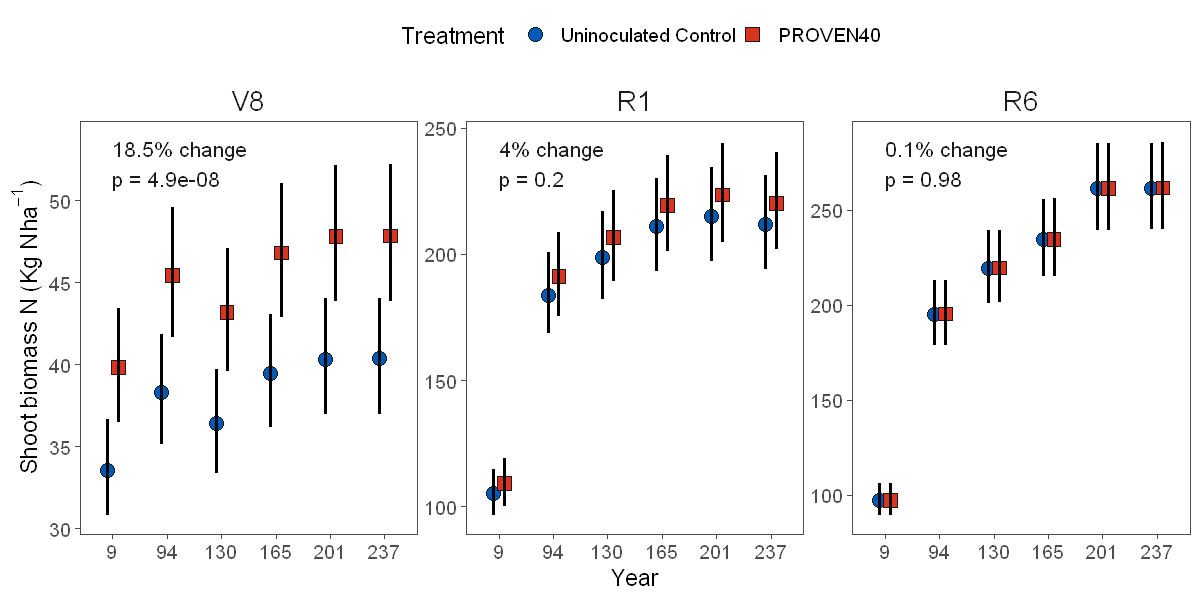

In [18]:

options(repr.plot.width=10, repr.plot.height=5)


up21_n_plot <-
as.data.frame(up21_n_mod_means) %>%  
ggplot(aes(factor(round(as.numeric(as.character(n_rate))/1.12 + 9,0)),response)) + 
geom_point(aes(colour = microbe, fill = microbe, shape = microbe), position = position_dodge(width = 0.4), size = 4, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression("Shoot biomass N (Kg N"~ha^-1*")"), x = "Year", colour = "", fill = "Treatment", shape = "Treatment") + 
scale_fill_manual(values = myColorPalette) +
scale_shape_manual( values = 21:22) + 
geom_text(aes(y = (max_value) + 1.5, label = my_label), data = up21_n_mod_trt_contrast %>% filter(n_rate == 0), colour = "gray10", vjust = 1, hjust = 0, size = 4.5) + 
facet_wrap(~stage, scales = "free_y") + 
theme(legend.position = "top")

up21_n_plot


In [19]:
up22_n <- filter(up_n, year == 2022)

head(up22_n)

,year,plot,rep,microbe,n_rate,stage,organ,measurement,units,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>
1,2022,101,1,PROVEN40,215,V8,shoot,n,kgha,33.22709
2,2022,102,1,Uninoculated Control,215,V8,shoot,n,kgha,29.04926
3,2022,103,1,PROVEN40,175,V8,shoot,n,kgha,28.30344
4,2022,104,1,Uninoculated Control,175,V8,shoot,n,kgha,33.96938
5,2022,105,1,PROVEN40,135,V8,shoot,n,kgha,25.67603
6,2022,106,1,Uninoculated Control,135,V8,shoot,n,kgha,33.95982


In [20]:
up22_n_mod_full <- lmer(log(value) ~ microbe*n_rate*stage +  (1|rep/n_rate), data = up21_n)

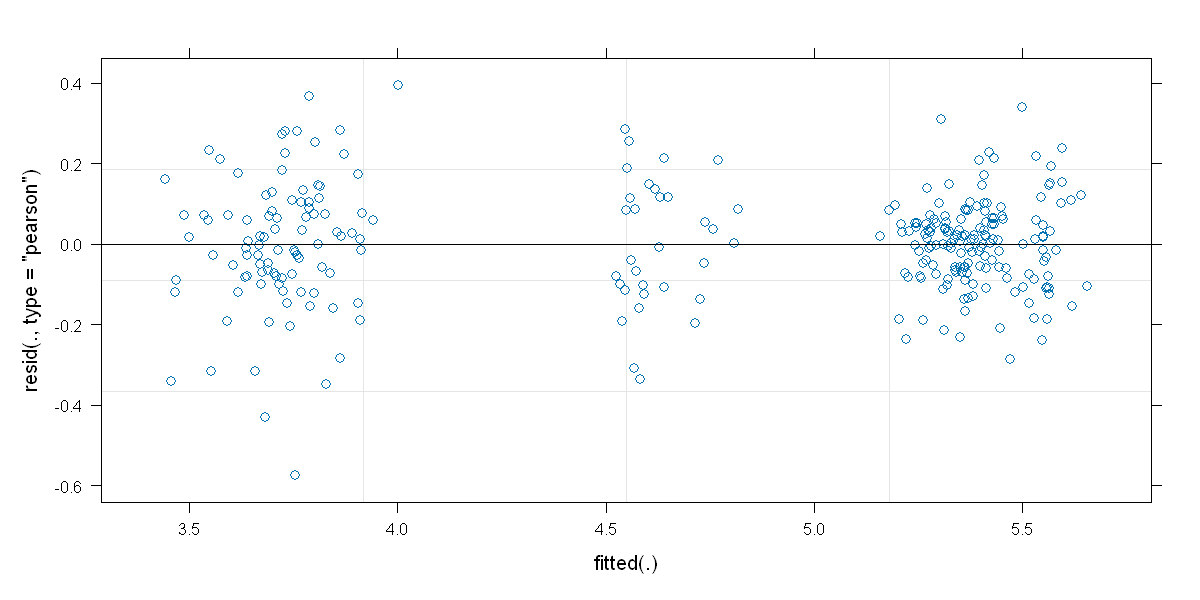

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98305, p-value = 0.001732


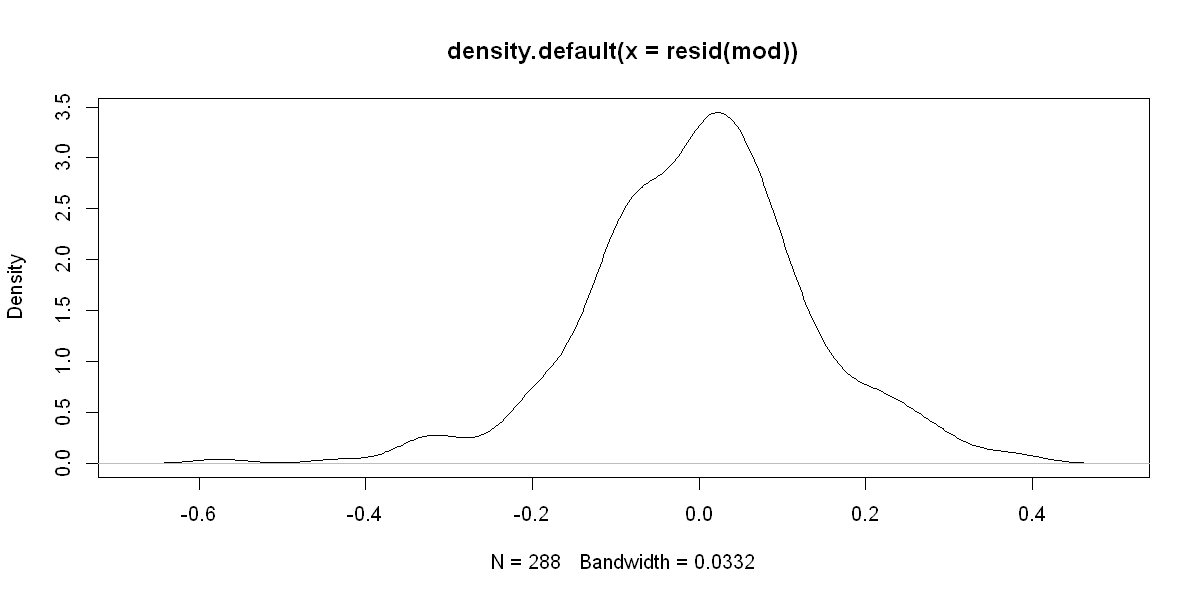

In [21]:
check_assumptions(up22_n_mod_full)

In [22]:
anova(up22_n_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
microbe,0.3511619,0.35116186,1,210.00004,15.8017424,9.673140e-05
n_rate,7.7873481,1.55746962,5,41.99995,70.0837311,2.796377e-19
stage,152.5791629,76.28958145,2,210.00004,3432.9135257,4.040131e-161
microbe:n_rate,0.1228116,0.02456233,5,210.00004,1.1052670,3.586435e-01
microbe:stage,0.3792827,0.18964136,2,210.00004,8.5335689,2.734173e-04
n_rate:stage,4.0708126,0.40708126,10,210.00004,18.3180288,6.892118e-24
microbe:n_rate:stage,0.1125362,0.01125362,10,210.00004,0.5063957,8.844988e-01


In [23]:
up22_n_mod_red1 <- lmer(log(value) ~ microbe*stage + n_rate*stage  +  (1|rep:n_rate), data = up22_n)

In [24]:
summary(up22_n_mod_red1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ microbe * stage + n_rate * stage + (1 | rep:n_rate)
   Data: up22_n

REML criterion at convergence: -93.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.04126 -0.52008  0.03681  0.58550  2.69632 

Random effects:
 Groups     Name        Variance Std.Dev.
 rep:n_rate (Intercept) 0.009754 0.09876 
 Residual               0.026963 0.16420 
Number of obs: 276, groups:  rep:n_rate, 46

Fixed effects:
                         Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)               3.05784    0.06010 113.33602  50.876  < 2e-16 ***
microbePROVEN40          -0.07268    0.03424 215.00000  -2.123 0.034911 *  
stageR1                   0.99011    0.06662 215.00000  14.862  < 2e-16 ***
stageR6                   1.32021    0.06662 215.00000  19.818  < 2e-16 ***
n_rate95                  0.19707    0.07889  99.04710   2.498 0.014139 *  
n_rate135      

In [25]:
up22_n_mod<- up22_n_mod_red1

In [26]:
up22_n_mod_means <- emmeans(up22_n_mod, ~ stage*microbe + n_rate*stage,  type = "response")
up22_n_mod_means

 stage microbe              n_rate response    SE  df lower.CL upper.CL
 V8    Uninoculated Control 0          21.3  1.28 113     18.9     24.0
 R1    Uninoculated Control 0          57.3  3.44 113     50.8     64.5
 R6    Uninoculated Control 0          79.7  4.79 113     70.7     89.8
 V8    PROVEN40             0          19.8  1.19 113     17.6     22.3
 R1    PROVEN40             0          56.4  3.39 113     50.1     63.5
 R6    PROVEN40             0          80.0  4.81 113     71.0     90.1
 V8    Uninoculated Control 95         25.9  1.47 115     23.2     29.0
 R1    Uninoculated Control 95        102.2  5.78 115     91.4    114.4
 R6    Uninoculated Control 95        168.1  9.51 115    150.3    188.0
 V8    PROVEN40             95         24.1  1.36 115     21.5     27.0
 R1    PROVEN40             95        100.7  5.69 115     90.0    112.6
 R6    PROVEN40             95        168.7  9.54 115    150.8    188.7
 V8    Uninoculated Control 135        28.9  1.73 113     25.6  

In [27]:
up22_n_mod_trt_contrast <- emmeans(up22_n_mod, ~ microbe, by = c("stage"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up22_n_mod_trt_contrast <- 
up22_n_mod_trt_contrast %>%
left_join(as.data.frame(up22_n_mod_means) %>% filter(microbe == "Uninoculated Control") %>% dplyr::select(stage,n_rate,response))  %>% 
mutate(pct_change = round(ratio - 1,3)*100,
my_label = 
paste0(
    pct_change,"% change\n",
    "p = ",signif(p.value,2)
    )
) %>% 
left_join(up22_n_mod_means %>% 
as.data.frame() %>%  
group_by(stage) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up22_n_mod_trt_contrast
 

Joining with `by = join_by(stage)`
Joining with `by = join_by(stage)`


contrast,stage,ratio,SE,df,null,t.ratio,p.value,n_rate,response,pct_change,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,0,21.28160,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,95,25.91727,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,135,28.86489,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,175,26.77143,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,215,28.65162,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,V8,0.9298950,0.03183863,215,1,-2.1228334,0.03491142,255,28.28892,-7.0,-7% change p = 0.035,32.51492
PROVEN40 / Uninoculated Control,R1,0.9849155,0.03372248,215,1,-0.4439216,0.65754574,0,57.28000,-1.5,-1.5% change p = 0.66,147.56438
PROVEN40 / Uninoculated Control,R1,0.9849155,0.03372248,215,1,-0.4439216,0.65754574,95,102.23349,-1.5,-1.5% change p = 0.66,147.56438
PROVEN40 / Uninoculated Control,R1,0.9849155,0.03372248,215,1,-0.4439216,0.65754574,135,110.91170,-1.5,-1.5% change p = 0.66,147.56438


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


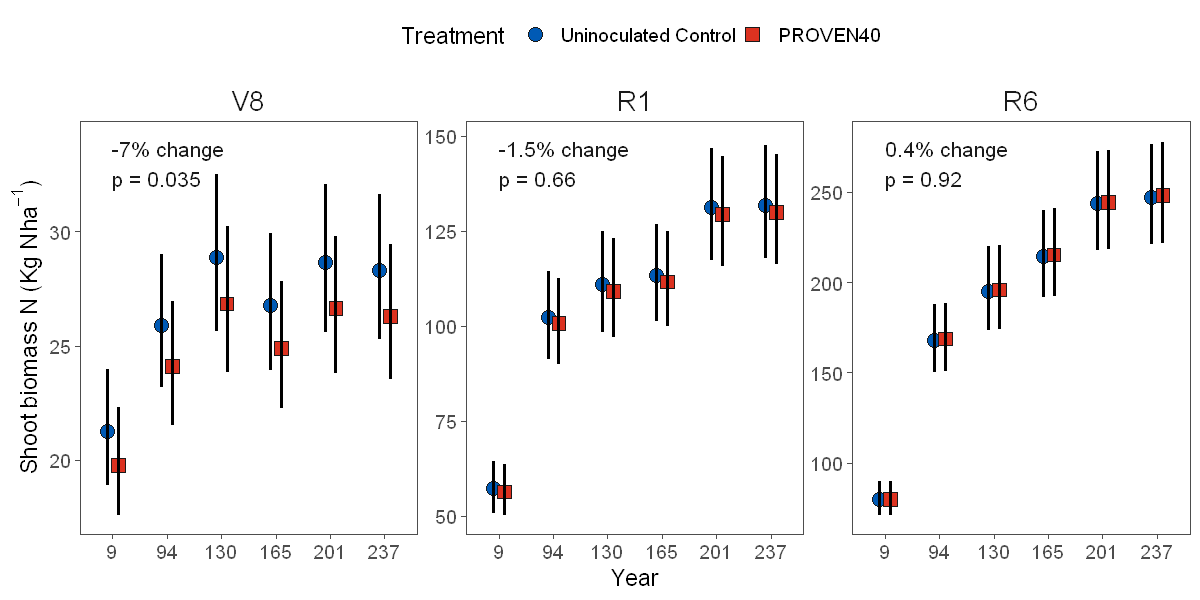

In [28]:

options(repr.plot.width=10, repr.plot.height=5)


up22_n_plot <-
as.data.frame(up22_n_mod_means) %>%  
ggplot(aes(factor(round(as.numeric(as.character(n_rate))/1.12 + 9,0)),response)) + 
geom_point(aes(colour = microbe, fill = microbe, shape = microbe), position = position_dodge(width = 0.4), size = 4, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression("Shoot biomass N (Kg N"~ha^-1*")"), x = "Year", colour = "", fill = "Treatment", shape = "Treatment") + 
scale_fill_manual(values = myColorPalette) +
scale_shape_manual( values = 21:22) + 
geom_text(aes(y = (max_value) + 1.5, label = my_label), data = up22_n_mod_trt_contrast %>% filter(n_rate == 0), colour = "gray10", vjust = 1, hjust = 0, size = 4.5) + 
facet_wrap(~stage, scales = "free_y") + 
theme(legend.position = "top")

up22_n_plot


In [29]:
up_n_mod_full <- lmer(log(value) ~ microbe*n_rate*stage*year +  (1|year:rep:n_rate), data = up_n)

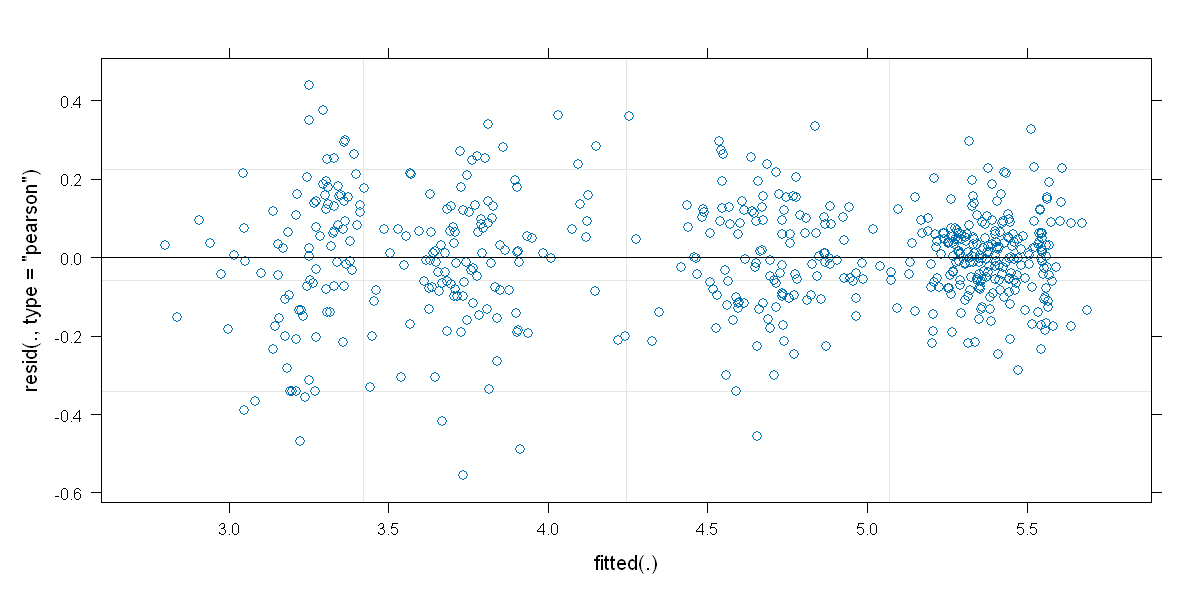

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98718, p-value = 7.396e-05


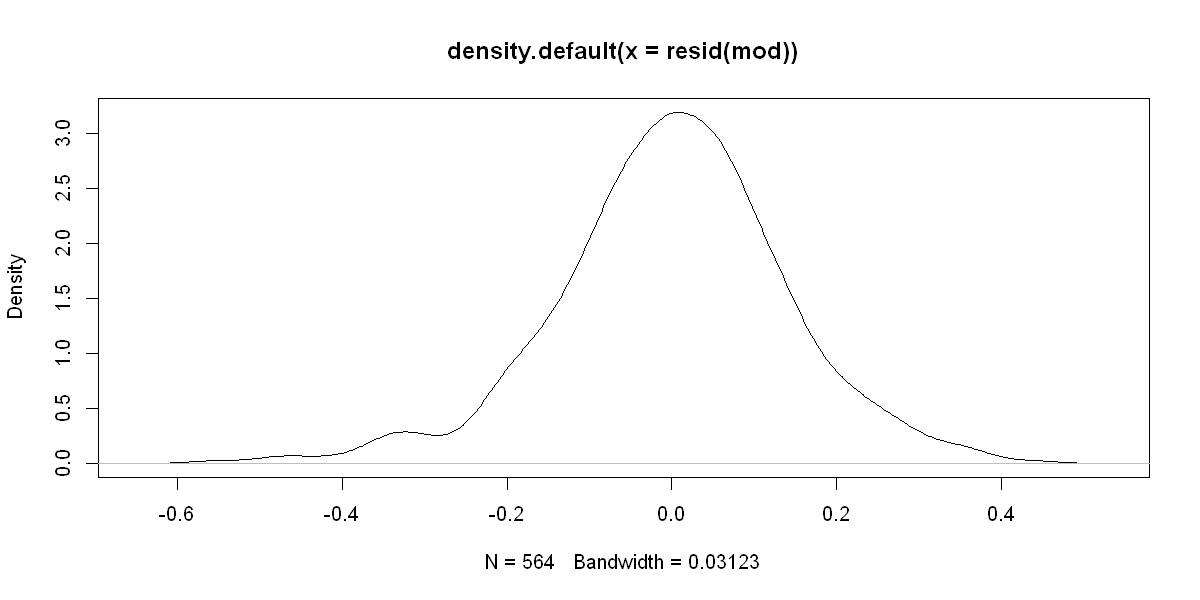

In [30]:
check_assumptions(up_n_mod_full)

In [31]:
anova(up_n_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
microbe,0.05803398,5.803398e-02,1,410,2.3099810,1.293164e-01
n_rate,12.49407133,2.498814e+00,5,82,99.4626529,2.541735e-33
stage,333.14280810,1.665714e+02,2,410,6630.1981562,6.103292e-313
year,8.89191138,8.891911e+00,1,82,353.9331062,1.729508e-31
microbe:n_rate,0.03771721,7.543441e-03,5,410,0.3002587,9.126049e-01
microbe:stage,0.05332656,2.666328e-02,2,410,1.0613036,3.469531e-01
n_rate:stage,7.58850841,7.588508e-01,10,410,30.2052533,1.842306e-43
microbe:year,0.34497180,3.449718e-01,1,410,13.7312366,2.398518e-04
n_rate:year,0.11964563,2.392913e-02,5,82,0.9524735,4.519133e-01


In [32]:
up_n_mod_red1 <- lmer(log(value) ~ microbe*stage*year + n_rate*stage*year +  (1|year:rep:n_rate), data = up_n)

In [33]:
summary(up_n_mod_red1)


Correlation matrix not shown by default, as p = 42 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ microbe * stage * year + n_rate * stage * year +  
    (1 | year:rep:n_rate)
   Data: up_n

REML criterion at convergence: -264.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8198 -0.5231  0.0426  0.5558  2.8652 

Random effects:
 Groups          Name        Variance Std.Dev.
 year:rep:n_rate (Intercept) 0.006218 0.07885 
 Residual                    0.024316 0.15594 
Number of obs: 564, groups:  year:rep:n_rate, 94

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                        3.514243   0.050501 273.903363  69.588
microbePROVEN40                    0.170088   0.031831 440.000000   5.344
stageR1                            1.141443   0.059550 439.999999  19.168
stageR6                            1.061130   0.059550 439.999999  17.819
year2022                          -0.456400   0.073755 272.157379  

In [34]:
up_n_mod <- up_n_mod_red1

In [35]:
up_n_mod_means <- emmeans(up_n_mod, ~ stage*microbe*year + n_rate*year,  type = "response")
up_n_mod_means

 stage microbe              year n_rate response    SE  df lower.CL upper.CL
 V8    Uninoculated Control 2021 0          33.6  1.70 274     30.4     37.1
 R1    Uninoculated Control 2021 0         105.2  5.31 274     95.2    116.2
 R6    Uninoculated Control 2021 0          97.1  4.90 274     87.9    107.2
 V8    PROVEN40             2021 0          39.8  2.01 274     36.1     44.0
 R1    PROVEN40             2021 0         109.3  5.52 274     99.0    120.8
 R6    PROVEN40             2021 0          97.1  4.90 274     87.9    107.3
 V8    Uninoculated Control 2022 0          21.3  1.14 271     19.1     23.7
 R1    Uninoculated Control 2022 0          57.3  3.08 271     51.5     63.7
 R6    Uninoculated Control 2022 0          79.7  4.28 271     71.7     88.6
 V8    PROVEN40             2022 0          19.8  1.06 271     17.8     22.0
 R1    PROVEN40             2022 0          56.4  3.03 271     50.8     62.7
 R6    PROVEN40             2022 0          80.0  4.30 271     71.9     88.9

In [36]:
up_n_mod_trt_contrast <- emmeans(up_n_mod, ~ microbe, by = c("stage","year"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up_n_mod_trt_contrast <- 
up_n_mod_trt_contrast %>%
left_join(as.data.frame(up_n_mod_means) %>% filter(microbe == "Uninoculated Control") %>% dplyr::select(stage,n_rate,response))  %>% 
mutate(pct_change = round(ratio - 1,3)*100,
my_label = 
paste0(
    pct_change,"% change\n",
    "p = ",signif(p.value,2)
    )
) %>% 
left_join(up_n_mod_means %>% 
as.data.frame() %>%  
group_by(stage,year) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up_n_mod_trt_contrast
 

Joining with `by = join_by(stage)`
Warning message in left_join(., as.data.frame(up_n_mod_means) %>% filter(microbe == :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 1 of `x` matches multiple rows in `y`.
i Row 1 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."
`summarise()` has grouped output by 'stage'. You can override using the
`.groups` argument.
Joining with `by = join_by(stage, year)`


contrast,stage,year,ratio,SE,df,null,t.ratio,p.value,n_rate,response,pct_change,my_label,max_value
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,0,33.59049,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,0,21.28160,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,95,38.33972,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,95,25.91727,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,135,36.42203,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,135,28.86489,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,175,39.49069,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,175,26.77143,18.5,18.5% change p = 1.5e-07,52.85071
PROVEN40 / Uninoculated Control,V8,2021,1.185409,0.03773223,440,1,5.34353741,1.465878e-07,215,40.34483,18.5,18.5% change p = 1.5e-07,52.85071


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


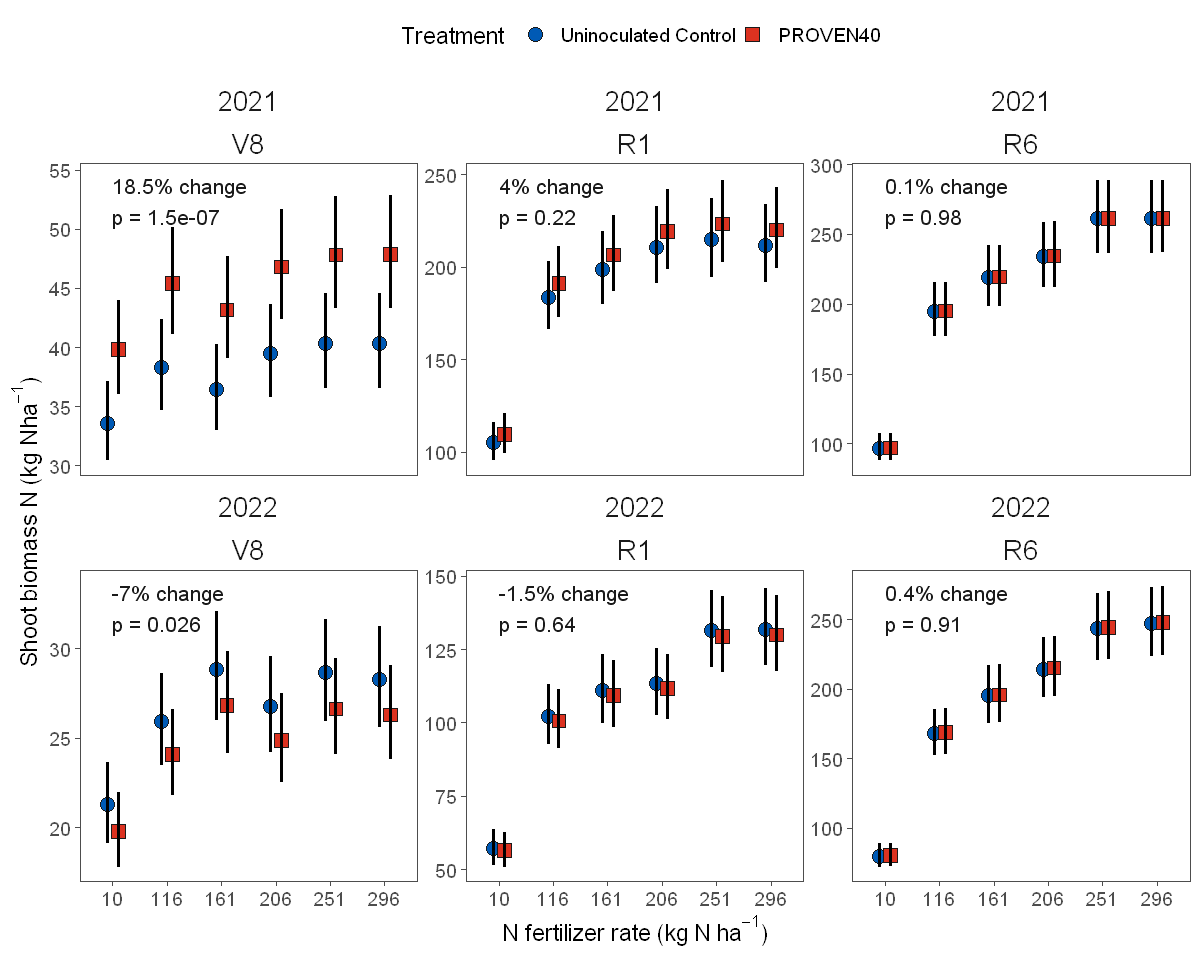

In [41]:

options(repr.plot.width=10, repr.plot.height=8)


up_n_plot <-
as.data.frame(up_n_mod_means) %>%  
ggplot(aes(factor(round(as.numeric(as.character(n_rate))*1.12 + 10,0)),response)) + 
geom_point(aes(colour = microbe, fill = microbe, shape = microbe), position = position_dodge(width = 0.4), size = 4, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression("Shoot biomass N (kg N"~ha^-1*")"), x = expression("N fertilizer rate (kg N"~ha^-1*")"), shape = "Treatment", fill = "Treatment") + 
scale_fill_manual(values = myColorPalette) +
scale_shape_manual(values = c(21,22)) + 
geom_text(aes(y = (max_value) + 1.5, label = my_label), data = up_n_mod_trt_contrast %>% filter(n_rate == 0), colour = "gray10", vjust = 1, hjust = 0, size = 4.5) + 
facet_wrap(year~stage, scales = "free_y") + 
theme(legend.position = "top")

up_n_plot

ggsave("./figures/shoot_biomass_n.png",width =10, height = 8, dpi = 300, bg = "white")


In [42]:
ndfa_join <- emmeans(up_n_mod, ~ stage*microbe*year,  type = "response") %>% 
data.frame() %>% 
filter(microbe == "PROVEN40", stage == "R1") %>% 
mutate(year = as.numeric(as.character(year))) %>%
left_join(readRDS("./datasets/UPurdue_whole_plant_d15n.rds"), by =c("year","stage"))

ndfa_join


stage,microbe,year,response,SE.x,df.x,lower.CL,upper.CL,contrast,ratio,SE.y,df.y,null,t.ratio,p.value,ndfa,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
R1,PROVEN40,2021,189.7032,4.784642,420.0408,180.52766,199.3450,PROVEN40 / Uninoculated Control,0.8976056,0.04318890,223.0124,1,-2.245099,0.02574280,10.2,Ndfa = 10.2% p = 0.026,2.062464
R1,PROVEN40,2022,102.5846,2.646164,419.5553,97.51291,107.9201,PROVEN40 / Uninoculated Control,0.8640633,0.07358159,214.0130,1,-1.715751,0.08765486,13.6,Ndfa = 13.6% p-value = 0.088,1.278412


In [43]:
ndfa_join %>%
transmute(
    year,
    response,
    response_se = SE.x,
    ndfa = 1 - ratio,
    ratio_se = SE.y,
    ndfa_nmass = (1 - ratio)*response,
    ndfa_nmass_se = ndfa_nmass*sqrt((SE.x/response)^2 + (SE.y/(1-ratio))^2),
    margin =  qt(1 - 0.05/2,df=df.y)*ndfa_nmass_se,
    ndfa_nmass_upperCL =  ndfa_nmass + margin,
    ndfa_nmass_lowerCL =  ndfa_nmass - margin) %>%
mutate_all(signif,digits = 4)


year,response,response_se,ndfa,ratio_se,ndfa_nmass,ndfa_nmass_se,margin,ndfa_nmass_upperCL,ndfa_nmass_lowerCL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021,189.7,4.785,0.1024,0.04319,19.42,8.208,16.17,35.60,3.2500
2022,102.6,2.646,0.1359,0.07358,13.95,7.557,14.90,28.84,-0.9505
